# Dynamic Parole Recommendation Simulator

In [7]:
import pandas as pd
import numpy as np
import random

np.random.seed(42)

# Constant values
N = 500
crime_types = ['Drug', 'Violent', 'Property', 'Public Order']
genders = ['Male', 'Female']
races = ['White', 'Black', 'Latinx', 'Asian']

# Generate static data
data = {
    'case_id': range(1, N+1),
    'age': np.random.randint(18, 76, N),
    'gender': np.random.choice(genders, N, p = [0.82, 0.18]),
    'race': np.random.choice(races, N, p = [0.3, 0.4, 0.2, 0.1]),
    'crime_type': np.random.choice(crime_types, N, p=[0.35, 0.30, 0.25, 0.10]),
    'prior_offenses': np.random.poisson(1.5, N),}

def assign_sentence_years(crime_type, prior_offenses):
    base = {
        'Drug': np.random.randint(1, 8),
        'Property': np.random.randint(2, 10),
        'Public Order': np.random.randint(1, 6),
        'Violent': np.random.randint(10, 25)
    }[crime_type]
    
    # Priors do make things worse, but not linearly
    modifier = int(prior_offenses * np.random.uniform(0.5, 1.2))
    
    return base + modifier


# Create the initial DataFrame
df = pd.DataFrame(data)

# Assign sentence_years using crime_type and prior_offenses
df['sentence_years'] = df.apply(
    lambda row: assign_sentence_years(row['crime_type'], row['prior_offenses']),
    axis=1)

# Now that we have sentence_years, generate years_served ≤ sentence_years
df['years_served'] = df['sentence_years'].apply(lambda x: random.randint(1, x))


# Static parole recommendation based on sentence length, prior offenses, crime type
def recommend_static(row):
    score = 0
    if row['crime_type'] == 'Drug':
        score += 2
    if row['prior_offenses'] == 0:
        score += 2
    if row['sentence_years'] <= 5:
        score += 2
    if row['age'] >= 50:
        score += 1
    return 1 if score >= 4 else 0

df['parole_recommended_static'] = df.apply(recommend_static, axis=1)

# Add dynamic behavior-related factors
df['completed_rehab_program'] = np.random.choice([1, 0], size=N, p=[0.46, 0.54])
df['employment_training_participation'] = np.random.choice([1, 0], size=N, p=[0.4, 0.6])
df['recent_disciplinary_actions'] = np.random.poisson(0.7, N)
df['family_visitation_last_6mo'] = np.random.choice([1, 0], size=N, p=[0.35, 0.65])

def recommend_dynamic(row):
    score = 0
    # Static factors
    if row['crime_type'] == 'Drug':
        score += 2
    elif row['crime_type'] == 'Violent':
        score -= 1
    elif row['crime_type'] == 'Public Order':
        score += 1
    if row['prior_offenses'] == 0:
        score += 2
    if row['sentence_years'] <= 5:
        score += 1
    if row['age'] >= 60:
        score += 1
    # Dynamic factors
    if row['completed_rehab_program'] == 1:
        score += 1
    if row['employment_training_participation'] == 1:
        score += 1
    if row['recent_disciplinary_actions'] >= 2:
        score -= 1
    if row['family_visitation_last_6mo'] == 1:
        score += 1
    return 1 if score >= 5 else 0

df['parole_recommended_dynamic'] = df.apply(recommend_dynamic, axis=1)


df.head()

,case_id,age,gender,race,crime_type,prior_offenses,sentence_years,years_served,parole_recommended_static,completed_rehab_program,employment_training_participation,recent_disciplinary_actions,family_visitation_last_6mo,parole_recommended_dynamic
0,1,56,Male,White,Violent,0,16,13,0,1,0,0,0,0
1,2,69,Male,Black,Drug,3,7,3,0,1,0,0,0,0
2,3,46,Female,Black,Violent,0,13,12,0,1,0,1,0,0
3,4,32,Male,Black,Property,1,7,4,0,0,0,2,0,0
4,5,60,Male,White,Property,0,8,8,0,0,1,0,0,0


In [8]:
# Compare static vs dynamic recommendation outcomes
comparison = df[['parole_recommended_static', 'parole_recommended_dynamic']].value_counts().reset_index(name='count')
comparison = comparison.sort_values(by='count', ascending=False)
comparison

,parole_recommended_static,parole_recommended_dynamic,count
0,0,0,363
1,1,1,80
2,1,0,45
3,0,1,12


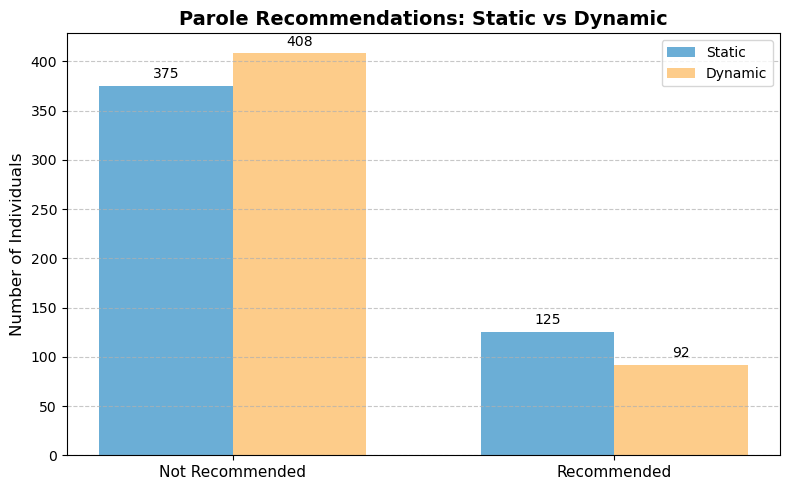

In [9]:
import matplotlib.pyplot as plt

# Softer color scheme
static_color = '#6baed6'     # soft blue
dynamic_color = '#fdcc8a'    # warm beige-orange

# Value counts
static_counts = df['parole_recommended_static'].value_counts().sort_index()
dynamic_counts = df['parole_recommended_dynamic'].value_counts().sort_index()

# Setup
labels = ['Not Recommended', 'Recommended']
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - width/2, static_counts, width, label='Static', color=static_color)
bars2 = ax.bar(x + width/2, dynamic_counts, width, label='Dynamic', color=dynamic_color)

# Add data labels above each bar
for bar in bars1 + bars2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 5, int(yval), ha='center', va='bottom', fontsize=10)

# Format
ax.set_ylabel('Number of Individuals', fontsize=12)
ax.set_title('Parole Recommendations: Static vs Dynamic', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=11)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Summary & Key Takeaway
### This project simulates how incorporating dynamic, behavior-based data into parole recommendations can meaningfully shift outcomes compared to traditional, static eligibility criteria.

## Findings:

#### 12 individuals (2.4%) were newly recommended for parole using dynamic factors like rehabilitation, employment training, and visitation.

#### 45 individuals were no longer recommended due to negative behavioral signals such as disciplinary actions.

#### While the shift may seem modest, extrapolated to a population of 100,000 incarcerated individuals, this approach could positively impact over 11,000 people, potentially reducing incarceration rates and improving outcomes at scale.

## To Clarify the Impact:
### Although the **overall number of parole recommendations decreased** when dynamic factors were introduced, this result is not a failure — it's a refinement.

### Dynamic data helped:
#### - Identify **positive change** by approving candidates actively working toward reintegration
#### - Flag **emerging risks** such as recent infractions, guiding support over premature release

### **Dynamic models don’t just increase release, they increase **precision**.**

## Conclusion:
### Even modest shifts in eligibility criteria, driven by rehabilitative signals, can safely and meaningfully improve release decisions — potentially impacting thousands of lives and millions in public cost savings across state systems.

### This simulation reflects how **data-informed decisions** can strengthen public safety, support reentry, and advance evidence-based justice reform at scale.